In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from yellowbrick.cluster import KElbowVisualizer
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.ensemble import RandomForestClassifier
from flask import Flask,render_template,request,flash
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

### 1. Data Preparation

In [2]:
# Load the dataset
credit_data = pd.read_csv('CC GENERAL.csv')
credit_data.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### 2. Exploratory Data Analysis (EDA)

**Drop the CUST_ID column which does not add any information for our EDA**

In [3]:
# Save the customer IDs to a list which will be added back to the list once we are saving the file
customer_ids = credit_data[["CUST_ID"]]

credit_data = credit_data.drop(columns = "CUST_ID").copy()
credit_data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


**Check the columns in the dataset**

In [4]:
credit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 17 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BALANCE                           8950 non-null   float64
 1   BALANCE_FREQUENCY                 8950 non-null   float64
 2   PURCHASES                         8950 non-null   float64
 3   ONEOFF_PURCHASES                  8950 non-null   float64
 4   INSTALLMENTS_PURCHASES            8950 non-null   float64
 5   CASH_ADVANCE                      8950 non-null   float64
 6   PURCHASES_FREQUENCY               8950 non-null   float64
 7   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 8   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 9   CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 10  CASH_ADVANCE_TRX                  8950 non-null   int64  
 11  PURCHASES_TRX                     8950 non-null   int64  
 12  CREDIT

The dataset now contains only int and float data, which will not require any transformation to be used by the models we are going to create

**Check for NaN values**

In [5]:
credit_data.isnull().sum()

BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

We observe that the 'MINIMUM_PAYMENTS' and 'CREDIT_LIMIT' columns contain null values.

**Check the distribution of the data**

In [6]:
plt.style.use("seaborn-v0_8-white")

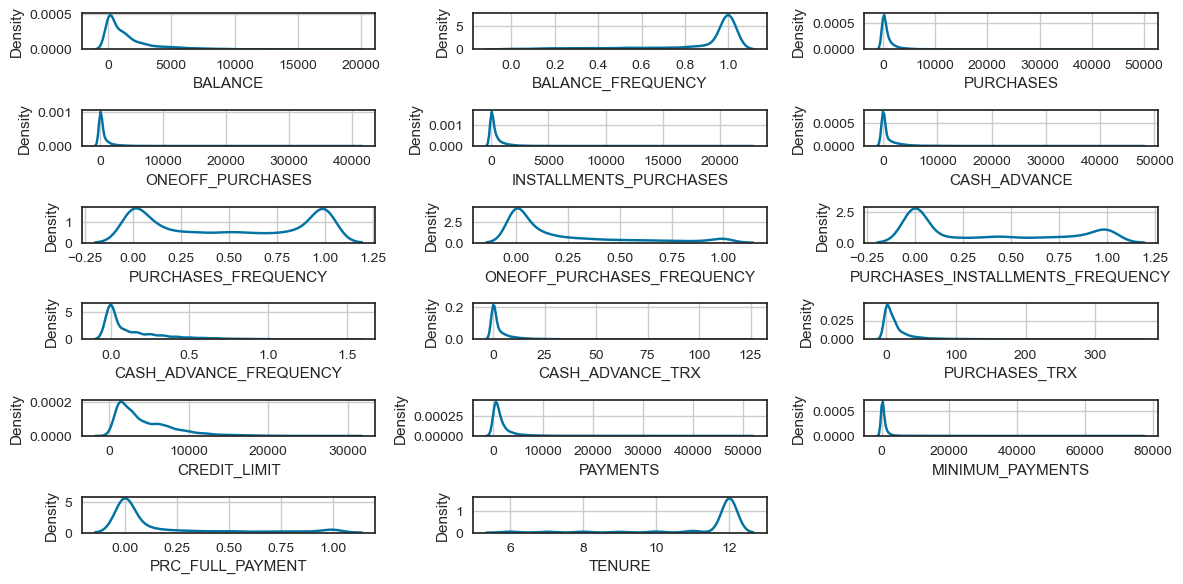

In [7]:
plt.figure(figsize = (12,6))
plt.title("Credit Data Dsitributions")
rows=6
cols=3
it=1
for i in credit_data.columns:
    plt.subplot(rows, cols,it)
    sns.kdeplot(credit_data[i])
    plt.grid()
    it+=1
plt.tight_layout()
plt.show()

The data is generally right skewed, except for 'PURCHASES_FREQUENCY' column where the tail is skewed to the left. This indicates that lower amounts across all columns for example purchases, cash advances, credit limits, etc.

'TENURE' is the only left-skewed column in the dataset. 

**Check for outliers in the dataset**

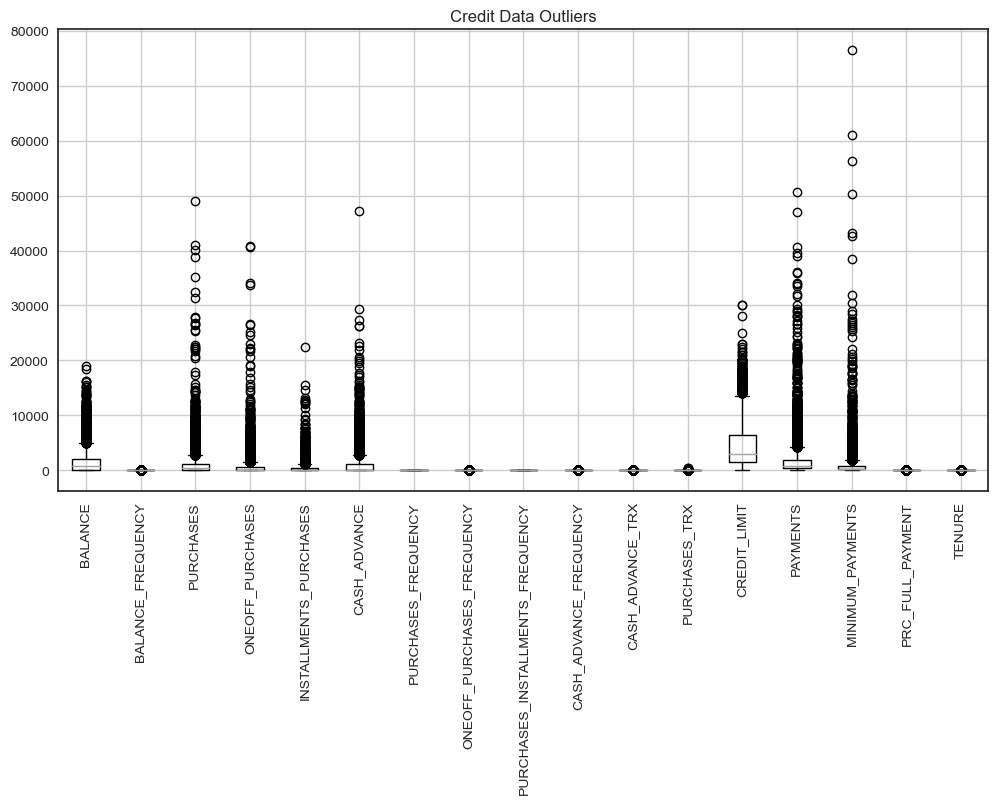

In [8]:
plt.figure(figsize = (12,6))
plt.title("Credit Data Outliers")
credit_data.boxplot()
plt.xticks(rotation=90)
plt.show()

The 'PURCHASES', 'ONEOFF_PURCHASES', 'CASH_ADVANCE', 'PAYMENTS' and 'MINIMUM_PAYMENTS' columns contain outliers. This indicates that some customers are transacting with significantly larger amounts than the general customer base.

### 3. Preprocessing

**Handle NaN values**

In [9]:
# Check for the range of values in the MINIMUM PAYMENTS column
credit_data[["MINIMUM_PAYMENTS", "CREDIT_LIMIT"]].describe()

,MINIMUM_PAYMENTS,CREDIT_LIMIT
count,8637.000000,8949.000000
mean,864.206542,4494.449450
std,2372.446607,3638.815725
min,0.019163,50.000000
25%,169.123707,1600.000000
50%,312.343947,3000.000000
75%,825.485459,6500.000000
max,76406.207520,30000.000000


In [10]:
# Handle NaN values using imputation
credit_data[["MINIMUM_PAYMENTS"]] = credit_data[["MINIMUM_PAYMENTS"]].fillna(credit_data[["MINIMUM_PAYMENTS"]].mean())
credit_data[["CREDIT_LIMIT"]] = credit_data[["CREDIT_LIMIT"]].fillna(credit_data[["CREDIT_LIMIT"]].mean())

# Check for NaN values again
credit_data.isnull().sum()

BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

First, I checked the 'MINIMUM_PAYMENTS' and 'CREDIT_LIMIT' columns using the describe() function to check the statistics in both columns. Understanding the mean, standard deviations and percentile statistics helps us determine whether imputation is the best approach to handle the NaN values.

This was confirmed, and I proceeded to handle Nan values using imputation with the mean values for each column.

**Handle Outliers**

In [11]:
cols = credit_data.columns.to_list()

# Get the Q1, Q3 and inter-quartile range values
Q1 = credit_data.quantile(0.25)
Q3 = credit_data.quantile(0.75)
IQR = Q3 - Q1
    
# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace the values below the lower bound with the Q1 value
credit_data[cols] = np.where(credit_data[cols] < lower_bound, Q1, credit_data[cols])
# Replace the values below the upper bound with the Q3 value
credit_data[cols] = np.where(credit_data[cols] > upper_bound, Q3, credit_data[cols])

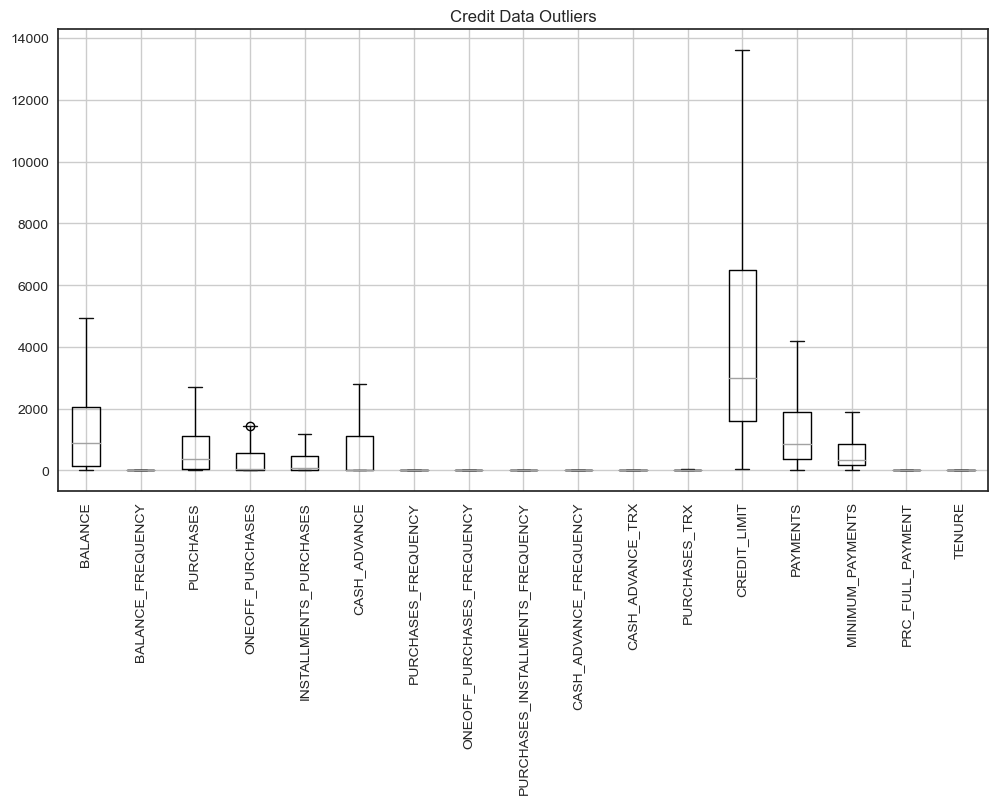

In [12]:
# Check for outliers again
plt.figure(figsize = (12,6))
plt.title("Credit Data Outliers")
credit_data.boxplot()
plt.xticks(rotation=90)
plt.show()

**Scale the data in the dataset**

In [13]:
# Check the columns before scaling
credit_data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.000,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0
1,3202.467416,0.909091,0.00,0.000,0.0,1113.821139,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0
2,2495.148862,1.000000,773.17,773.170,0.0,0.000000,1.000000,0.300000,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0
3,1666.670542,0.888889,1499.00,577.405,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,864.206542,0.000000,12.0
4,817.714335,1.000000,16.00,16.000,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0


In [14]:
# Scalre the data
scaler = StandardScaler()
credit_data_standardized = credit_data.copy()
credit_data_standardized[credit_data_standardized.columns] = scaler.fit_transform(
    credit_data_standardized[credit_data_standardized.columns])

# Check the columns after scaling
credit_data_standardized.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,-0.962212,-2.096860,-0.774370,-0.728838,-0.464370,-0.701189,-0.806490,-0.755587,-0.707313,-0.769592,-0.728211,-0.778845,-1.068173,-1.000708,-0.866047,-0.645249,0.0
1,1.741193,-0.746908,-0.923077,-0.728838,-0.799856,0.925232,-1.221758,-0.755587,-0.916995,1.036824,0.851308,-0.984624,0.924910,3.153647,1.351805,2.115847,0.0
2,1.136376,0.603044,0.282115,1.469575,-0.799856,-0.701189,1.269843,0.802808,-0.916995,-0.769592,-0.728211,0.250050,1.091001,-0.553176,0.293663,-0.645249,0.0
3,0.427958,-1.046897,1.413514,0.912942,-0.799856,-0.400693,-1.014125,-0.322701,-0.916995,-0.167456,-0.333331,-0.881734,1.091001,-1.215604,0.856957,-0.645249,0.0
4,-0.297971,0.603044,-0.898136,-0.683344,-0.799856,-0.701189,-1.014125,-0.322701,-0.916995,-0.769592,-0.728211,-0.881734,-1.001737,-0.493257,-0.615735,-0.645249,0.0


### 4. Unsupervised model creation and evaluation

**Create the KMeans Classification Model**

In [15]:
# Initialize the initial model
pre_kmeans_clf = KMeans(n_clusters=5, n_init=10, random_state=42, max_iter=300)

**Use the KElbowVisualizer to select the optimal number of clusters**

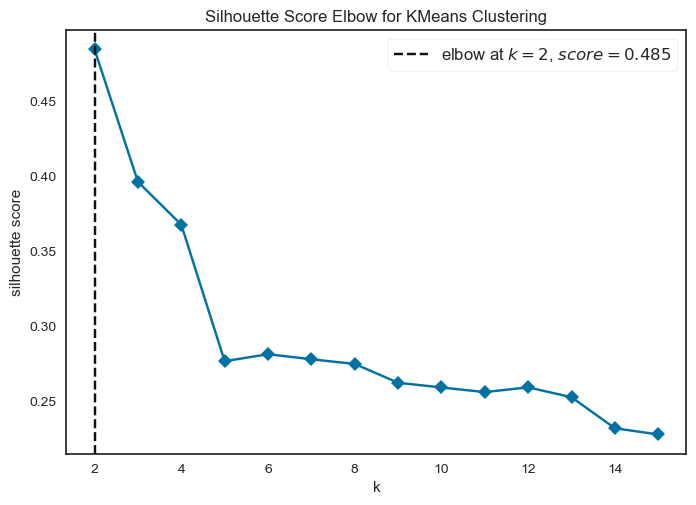

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [16]:
# Create and show the visualizer using clusters in range from 2 to 16
silhouette_visualizer=KElbowVisualizer(pre_kmeans_clf, k=(2,16), metric='silhouette', timings=False)
silhouette_visualizer.fit(credit_data)
silhouette_visualizer.show()

In [17]:
# Initialize the updated model
kmeans_clf = KMeans(n_clusters=2, n_init=10, random_state=42, max_iter=300)

In [18]:
# Create the cluster labels
cluster_labels = kmeans_clf.fit_predict(credit_data_standardized)
credit_data_standardized["Clusters"] = cluster_labels

credit_data_standardized.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,Clusters
0,-0.962212,-2.096860,-0.774370,-0.728838,-0.464370,-0.701189,-0.806490,-0.755587,-0.707313,-0.769592,-0.728211,-0.778845,-1.068173,-1.000708,-0.866047,-0.645249,0.0,1
1,1.741193,-0.746908,-0.923077,-0.728838,-0.799856,0.925232,-1.221758,-0.755587,-0.916995,1.036824,0.851308,-0.984624,0.924910,3.153647,1.351805,2.115847,0.0,1
2,1.136376,0.603044,0.282115,1.469575,-0.799856,-0.701189,1.269843,0.802808,-0.916995,-0.769592,-0.728211,0.250050,1.091001,-0.553176,0.293663,-0.645249,0.0,0
3,0.427958,-1.046897,1.413514,0.912942,-0.799856,-0.400693,-1.014125,-0.322701,-0.916995,-0.167456,-0.333331,-0.881734,1.091001,-1.215604,0.856957,-0.645249,0.0,1
4,-0.297971,0.603044,-0.898136,-0.683344,-0.799856,-0.701189,-1.014125,-0.322701,-0.916995,-0.769592,-0.728211,-0.881734,-1.001737,-0.493257,-0.615735,-0.645249,0.0,1


**Use PCA to reduce dimensionality and allow us to plot the clusters**

In [19]:
# Initialize the PCA model
pca = PCA(n_components = 2, whiten = False)

# Fit and transform the standardized dataset
credit_pca = pca.fit_transform(credit_data_standardized)
credit_pca = pd.DataFrame(data=credit_pca, columns=["PCA One", "PCA Two"])
credit_pca["Clusters"]= cluster_labels

credit_pca.head()

,PCA One,PCA Two,Clusters
0,-1.287644,-3.068967,1
1,-2.500400,1.976595,1
2,1.050887,0.858615,0
3,-0.861939,0.120992,1
4,-1.473201,-1.894193,1


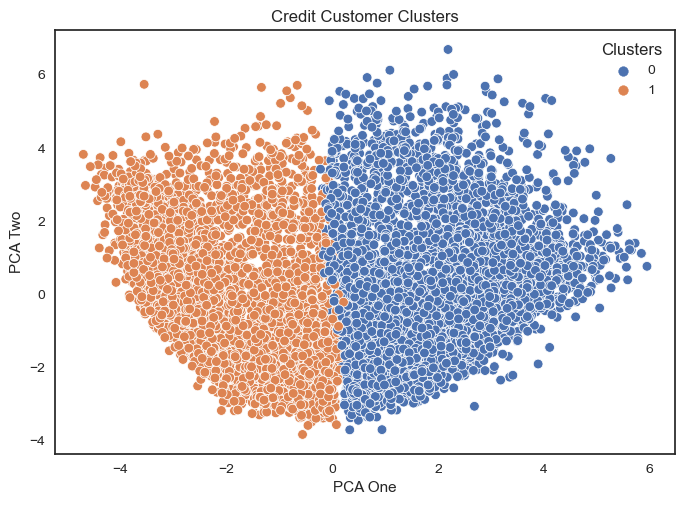

In [20]:
# Plot the clusters
plt.title("Credit Customer Clusters")
sns.scatterplot(x="PCA One", y="PCA Two", hue="Clusters", data=credit_pca, palette="deep")
plt.show()

**Evaulate the KMeans model**

<u>a) Silhouette Score evaluation</u>

The Silhouette Coefficient is calculated using the mean intra-cluster distance and the mean nearest-cluster distance for each sample. The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [21]:
# Print the silhouette score
s_score = silhouette_score(credit_pca, kmeans_clf.labels_)
print(f"Silhouette score : {s_score}")

Silhouette score : 0.43493676165944617


The unsupervised KMeans model has a good silhouette score of approximately 0.435. This indicates that the clusters formed by the model are on average well-separated, and the data points within each cluster are relatively close to each other compared to points in other clusters. This suggests a reasonable degree of cluster cohesion and separation, showing that our model can correctly identify the underlying patterns in the data

<u>b) Calinski and Harabasz Score evaluation</u>

This is also known as the Variance Ratio Criterion. The score is defined as ratio of the sum of between-cluster dispersion and of within-cluster dispersion. A high CH means better clustering since observations in each cluster are closer together (more dense), while clusters themselves are further away from each other (well separated)

In [22]:
# Print the Calinski and Harabasz score
ch_score = calinski_harabasz_score(credit_pca, kmeans_clf.labels_)
print(f"Calinski and Harabasz score : {ch_score}")

Calinski and Harabasz score : 7912.481449882473


The unsupervised KMeans model has a Calinski and Harabasz score of 7912.5. This suggests that the clusters formed by the model have a high degree of separation and compactness. Our score indicates strong cluster structures, showing that our model can correctly identify the underlying patterns in the data

**Creating and saving labelled dataset**

In [25]:
# Add the cluster labels and customer IDs as a column to the main dataframe
credit_data["CUST_ID"]= customer_ids
credit_data["CLUSTER"] = cluster_labels
credit_data.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,CUST_ID,CLUSTER
0,40.900749,0.818182,95.40,0.000,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0,C10001,1
1,3202.467416,0.909091,0.00,0.000,0.0,1113.821139,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0,C10002,1
2,2495.148862,1.000000,773.17,773.170,0.0,0.000000,1.000000,0.300000,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0,C10003,0
3,1666.670542,0.888889,1499.00,577.405,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,864.206542,0.000000,12.0,C10004,1
4,817.714335,1.000000,16.00,16.000,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0,C10005,1


In [26]:
# Save the dataframe into a CSV file
credit_data.to_csv('spiwan-cc-labeled.csv', index=False)

### 5. Supervised model creation and evaluation:

**Loading and splitting data into train and test**

In [27]:
# Load the dataset with the customer clusters identified
credit_clusters_df = pd.read_csv('spiwan-cc-labeled.csv')
credit_clusters_df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE,CUST_ID,CLUSTER
0,40.900749,0.818182,95.40,0.000,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0,C10001,1
1,3202.467416,0.909091,0.00,0.000,0.0,1113.821139,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0,C10002,1
2,2495.148862,1.000000,773.17,773.170,0.0,0.000000,1.000000,0.300000,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0,C10003,0
3,1666.670542,0.888889,1499.00,577.405,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,864.206542,0.000000,12.0,C10004,1
4,817.714335,1.000000,16.00,16.000,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0,C10005,1


In [28]:
# Set the X and y data
X = credit_clusters_df.drop(columns = {"CUST_ID", "CLUSTER"})
y = credit_clusters_df[["CLUSTER"]]

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [30]:
X_train.shape, y_train.shape

((6265, 17), (6265, 1))

In [31]:
X_test.shape, y_test.shape

((2685, 17), (2685, 1))

**Classification Model Comparision**

In [32]:
# Decision Tree
dtree_clf = DecisionTreeClassifier(random_state=30, max_depth=5)
dtree_clf.fit(X_train, y_train)
dtree_y_pred = dtree_clf.predict(X_test)
dtree_accuracy = accuracy_score(y_test, dtree_y_pred)
print(f"Decision Trees Accuracy Score : {round(dtree_accuracy, 3)}")

Decision Trees Accuracy Score : 0.951


In [33]:
dtree_crossval = cross_val_score(dtree_clf, X, y, cv=5).mean()
print(f"Decision Trees CrossVal Score : {round(dtree_crossval, 3)}")

Decision Trees CrossVal Score : 0.955


The accuracy scores above indicate that the Decision Tree Classifier has an accuracy score of 0.963 when using test_train_split(), and an accuracy score of 0.964 when using cross_val_score()

**Further checks on Decision Tree Scores**

In [34]:
# Use the classification report function to print the other scores
target_names =  ["Cluster 0", "Cluster 1"]
print(classification_report(y_test, dtree_y_pred, target_names=target_names))

              precision    recall  f1-score   support

   Cluster 0       0.96      0.94      0.95      1351
   Cluster 1       0.94      0.96      0.95      1334

    accuracy                           0.95      2685
   macro avg       0.95      0.95      0.95      2685
weighted avg       0.95      0.95      0.95      2685



From the scores above for the initial model with all features, we observe that:

The scores on 1351 instances of Cluster 0 customers were:

 - Precision score of 0.96, meaning 96% of the customers predicted as cluster 0 were actually cluster 0
 - Recall score of 0.94, meaning the model correctly idenitified 94% of the cluster 0 customers
 - F1 Score of 0.95
 
The scores on 2685 instances of Cluster 1 customers were:

 - Precision score of 0.94, meaning 94% of the customers predicted as cluster 1 were actually cluster 1
 - Recall score of 0.96, meaning the model correctly identified 96% of the cluster 1 customers
 - F1 Score of 0.95
 
The model has an overall accuracy of 0.95, meaning it correctly predicted 95% of the customer clusters. We can conclude that the DecisionTree model has a high classification performance on our credit customers dataset

**Learning Curves**

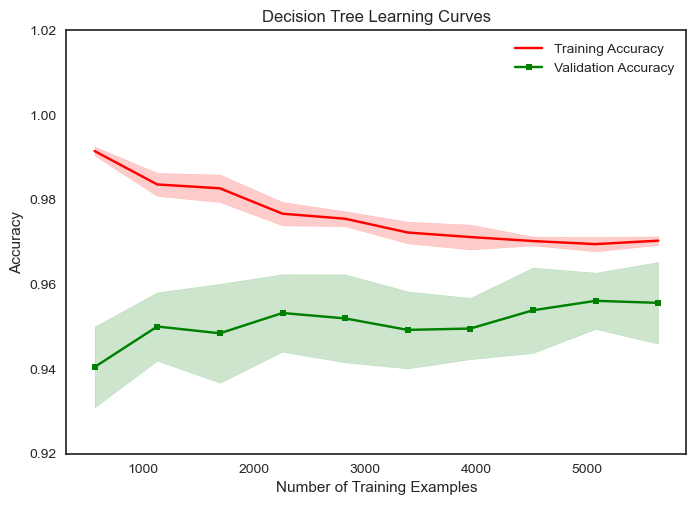

In [35]:
# Use the learning curve function with the decision tree estimator, X_train,
# y_train, 10 folds, 1 job and train sizes between 0.1 and 1 wth step size 0.1
train_sizes, train_scores, test_scores = learning_curve(
            estimator = dtree_clf, X=X_train, y=y_train,
            train_sizes=np.linspace(0.1,1.0,10),cv=10,n_jobs=1)

# Calculate the mean and standard deviation of the test and train scores
mean_train_score=np.mean(train_scores, axis=1)
train_std=np.std(train_scores, axis=1)

mean_test_score=np.mean(test_scores, axis=1)
test_std=np.std(test_scores, axis=1)

# Plot the learning curves
plt.plot(train_sizes, mean_train_score, color='red', marker='+', markersize=5, label="Training Accuracy")

plt.fill_between(train_sizes, mean_train_score+train_std, mean_train_score-train_std, alpha=0.2, color='red')

plt.plot(train_sizes, mean_test_score, color='green', marker='s', markersize=5, label="Validation Accuracy")

plt.fill_between(train_sizes, mean_test_score+test_std, mean_test_score-test_std, alpha=0.2, color='green')

plt.title("Decision Tree Learning Curves")
plt.xlabel('Number of Training Examples')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([0.920,1.020])
plt.show()

The learning curves show a significant gap between the training accuracy curve and validation accuracy curve with a low number of training examples, which indicated overfitting. However, this gap reduces as number of training examples increase, which indicates improvement in performance and a reduction in overfitting.

### 6. Feature Selection and Engineering

**Performing Feature Selection using the RandomForestClassifier**

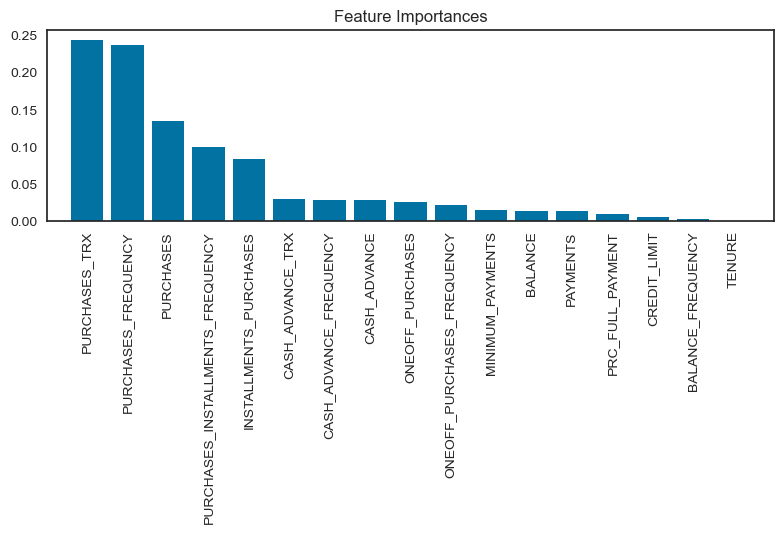

In [36]:
# Setup the RandomForestClassifier
random_forest=RandomForestClassifier(n_estimators=500,random_state=1)
random_forest.fit(X_train,y_train)

# Set the columnns from the X dataset as the labels for the graph
labels=X.columns

# Select the feature importances
feature_importances=random_forest.feature_importances_
feature_indices=np.argsort(feature_importances)[::-1]

plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), feature_importances[feature_indices], align='center')
plt.xticks(range(X_train.shape[1]),labels[feature_indices], rotation=90)
plt.xlim([-1,X_train.shape[1]])
plt.tight_layout()
plt.show()

In [37]:
# Select the features whose importance is greater than the mean importance
mean_importance = feature_importances.mean()

#Create a list to hold the labels of the features that qualify
optimal_features = []

for feature in range(X_train.shape[1]):
    if feature_importances[feature_indices[feature]] > mean_importance:
        optimal_features.append(labels[feature_indices[feature]])
        print("{:2d} {:25s} {:.3f}".format(feature+1, labels[feature_indices[feature]], 
                                       feature_importances[feature_indices[feature]]))

 1 PURCHASES_TRX             0.245
 2 PURCHASES_FREQUENCY       0.237
 3 PURCHASES                 0.136
 4 PURCHASES_INSTALLMENTS_FREQUENCY 0.100
 5 INSTALLMENTS_PURCHASES    0.084


I used the RandomForestClassifier to perform feature selection for the followung reasons:
- Compared to SelectFromModel feature selection where I would need to define my own threshold value, RandomForestClassifier ranks each feature by performance allowing for selection of the top n features. We can then use the mean importance value to select all features with importance above the mean value
- By creating multiple decision trees, the model iterates through all datapoints in the dataset, reducing the chances of overfitting

From the feature selection run and taking all features with importance above the mean threshold, we select 'PURCHASES_FREQUENCY', 'PURCHASES_TRX', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'INSTALLMENTS_PURCHASES' and 'PURCHASES' as the most important features. We will create a new model using these five features as the predictor variables

**Building a new model after feature selection**

In [38]:
# Set the new X data
X_optimal = credit_data[optimal_features]

# Set the new train and test data
X_train_opt, X_test_opt, y_train_opt, y_test_opt = train_test_split(
    X_optimal, y, test_size=0.3, random_state=42)

In [39]:
# Create the optimized decision Tree
dtree_clf_optimal = DecisionTreeClassifier(random_state=30)
dtree_clf_optimal.fit(X_train_opt, y_train_opt)
dtree_y_pred_optimal = dtree_clf_optimal.predict(X_test_opt)

# Print the classification report for the optmized decision trees model
print(classification_report(y_test_opt, dtree_y_pred_optimal, target_names=target_names))

              precision    recall  f1-score   support

   Cluster 0       0.93      0.91      0.92      1351
   Cluster 1       0.91      0.93      0.92      1334

    accuracy                           0.92      2685
   macro avg       0.92      0.92      0.92      2685
weighted avg       0.92      0.92      0.92      2685



From the scores above for the model with optimal features, we observe that:

The scores on 1351 instances of Cluster 0 customers were:

 - Precision score of 0.93, meaning 93% of the customers predicted as cluster 0 were actually cluster 0
 - Recall score of 0.91, meaning the model correctly idenitified 91% of the cluster 0 customers
 - F1 Score of 0.92
 
The scores on 2685 instances of Cluster 1 customers were:

 - Precision score of 0.91, meaning 91% of the customers predicted as cluster 1 were actually cluster 1
 - Recall score of 0.93, meaning the model correctly identified 93% of the cluster 1 customers
 - F1 Score of 0.92
 
The model has an overall accuracy of 0.92, which is lower than the initial accuracy of 0.95. While the model performance has lowered, this could be attributed to a reduction in the overfitting after feature selection. Therefore, we can conclude that the robustness of the model has improved

### 7. Hyperparameter tuning

**Comapring models before and after feature selection**

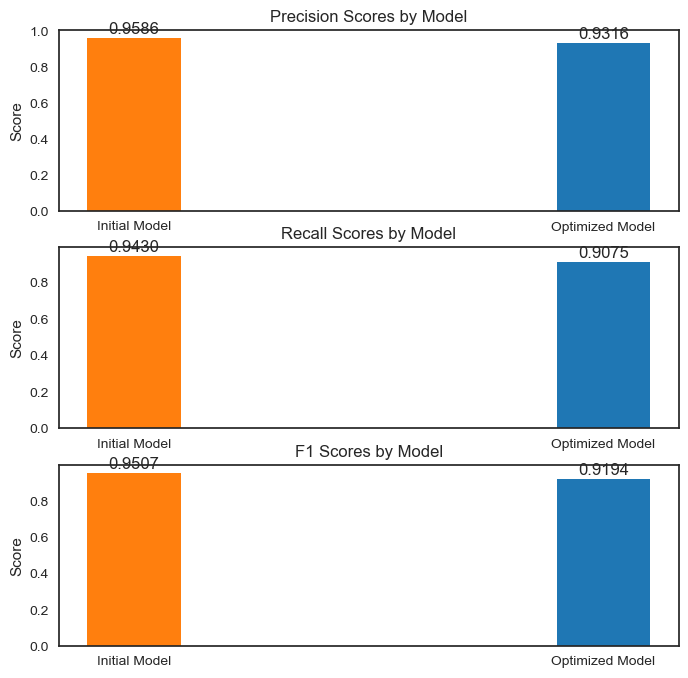

In [40]:
# Select scores from initial model
precision, recall, f1, support = precision_recall_fscore_support(y_test, dtree_y_pred)

# Select scores from the optimized model
precision_opt, recall_opt, f1_opt, support_opt = precision_recall_fscore_support(y_test_opt, dtree_y_pred_optimal)

precision_scores = [precision[0], precision_opt[0]]
recall_scores = [recall[0], recall_opt[0]]
f1_scores = [f1[0], f1_opt[0]]

# Recall scores plot
plot_labels = ["Initial Model", "Optimized Model"]

# Set up the subplots
fig, axs = plt.subplots(3, 1, figsize=(8, 8))

# Precision scores plot
axs[0].bar(plot_labels, precision_scores, color = ['tab:orange','tab:blue'], width=0.2)
axs[0].set_ylabel("Score") 
axs[0].set_title("Precision Scores by Model")
for i , v in enumerate(precision_scores):
    axs[0].text(i, v + 0.01 ,f'{v:.4f}', ha='center', va='bottom' )
    
# Recall scores plot
axs[1].bar(plot_labels, recall_scores, color = ['tab:orange','tab:blue'], width=0.2)
axs[1].set_ylabel("Score") 
axs[1].set_title("Recall Scores by Model")
for i , v in enumerate(recall_scores):
    axs[1].text(i, v + 0.01 ,f'{v:.4f}', ha='center', va='bottom' )
    
# F1 scores plot
axs[2].bar(plot_labels, f1_scores, color = ['tab:orange','tab:blue'], width=0.2)
axs[2].set_ylabel("Score") 
axs[2].set_title("F1 Scores by Model")
for i , v in enumerate(f1_scores):
    axs[2].text(i, v + 0.01 ,f'{v:.4f}', ha='center', va='bottom' )
plt.show() 

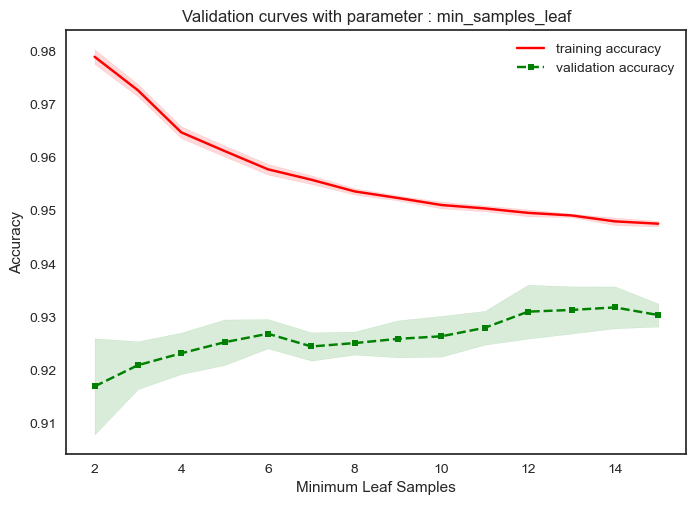

In [41]:
# Plot the validation curve
param_range = range(2,16)

train_scores, test_scores=validation_curve(estimator=dtree_clf_optimal, X=X_train_opt, y=y_train_opt,
                                                     param_name='min_samples_leaf',
                                         param_range=param_range)
train_mean=np.mean(train_scores,axis=1)
train_std=np.std(train_scores,axis=1)

test_mean=np.mean(test_scores,axis=1)
test_std=np.std(test_scores,axis=1)

plt.plot(param_range, train_mean, color='red', marker='+', markersize=5, label='training accuracy')

plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='red')

plt.plot(param_range, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='validation accuracy')

plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='green')

plt.xlabel('Minimum Leaf Samples')
plt.ylabel('Accuracy')
plt.title("Validation curves with parameter : min_samples_leaf")
plt.legend()
plt.show()

The curves show a significant gap between the training accuracy curve and validation accuracy curve with a low number of leaves, which indicated overfitting. However, this gap reduces as number of leaves increase, which indicates improvement in performance and a reduction in overfitting.

**Hyperparameter tuning using GridSearch**

In [42]:
# Setup the dictionary of parameters
# {'kernel':('linear', 'rbf'), 'C':[1, 10]}
parameters = {
    'criterion' : ["gini", "entropy", "log_loss"],
    'max_depth' : range(2,20),
    'min_samples_leaf' : range(2,20),
    'max_leaf_nodes' : range(2,20)
}

# Use the model with optimized features for the GridSearch
gridsearch_clf = GridSearchCV(estimator = dtree_clf_optimal,
                             param_grid=parameters,
                             scoring='accuracy')
gd_search=gridsearch_clf.fit(X_train_opt, y_train_opt)                          

In [43]:
# Display the best estimator
dtree_clf_final = gd_search.best_estimator_
dtree_clf_final

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=19, min_samples_leaf=18,
                       random_state=30)

In [44]:
# Print the best accuracy score
print(f"Best Accuracy Score : {round(gd_search.best_score_, 3)}")

Best Accuracy Score : 0.935


**Comparing performance of model with optimal features and hyperparametized model**

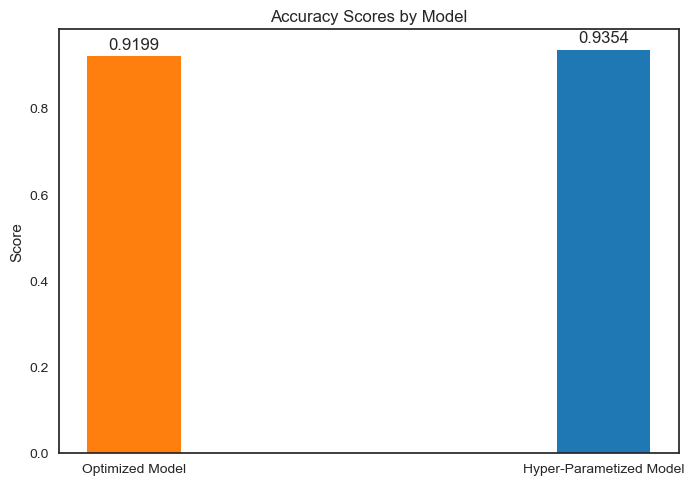

In [45]:
# Accuarcy scores plot
plot_labels_final = ["Optimized Model", "Hyper-Parametized Model"]

# Get the accuracy score of the model with selected features
accuracy_score_opt = accuracy_score(y_test_opt, dtree_y_pred_optimal)

final_accuracy_scores = [accuracy_score_opt,gd_search.best_score_]
# Precision scores plot
plt.bar(plot_labels_final, final_accuracy_scores, color = ['tab:orange','tab:blue'], width=0.2)
plt.ylabel("Score") 
plt.title("Accuracy Scores by Model")
for i , v in enumerate(final_accuracy_scores):
    plt.text(i, v + 0.01 ,f'{v:.4f}', ha='center', va='bottom' )
plt.show() 

The optimized model that uses selected features has accuracy score of 0.92, while the hyper-parametized model has an accuracy score of 0.94 . 

Therefore, because the hyper-parametized model considers both optimally selected features and the best hyperparameters, we can conclude that this model has the best overall performance and should be selected as the final benchmark model.

**Save the final benchmark model to a pickle file**

In [46]:
if not os.path.exists('models'):
    os.makedirs('models')
with open('models/decision_tree_model.pkl', 'wb') as file:
    pickle.dump(dtree_clf_final, file)

### 8. Model deployment

In [47]:
# Load the saved benchamrk model
benchmark_model = pickle.load(open('models/decision_tree_model.pkl','rb'))

In [48]:
# Create the app
app=Flask(__name__)

# Configure the app
app.logger.setLevel('INFO')
app.secret_key = "aliciakeys"

# Defining the application routes

# Define the home route
@app.route('/')
def home():
    return render_template('index.html')

@app.route('/predict',methods=['GET','POST'])
def predict():
    if request.method == 'POST':
        try:
            # Fetch the form inputs
            purchase_frequency = float(request.form['PURCHASES_FREQUENCY'])
            purchases_trx = float(request.form['PURCHASES_TRX'])
            purchases_installments_freq = float(request.form['PURCHASES_INSTALLMENTS_FREQUENCY'])
            installments_purchases = float(request.form['INSTALLMENTS_PURCHASES'])
            purchases = float(request.form['PURCHASES'])
            # Load the inputs into a list
            inputs = [purchase_frequency, purchases_trx, purchases_installments_freq,
                      installments_purchases, purchases]

            input_array = np.array(inputs)
            inputs_values = input_array.reshape(1,-1)
            
            classification_result = benchmark_model.predict(inputs_values)
            
            # Generate the results that will be displayed to the user
            if int(classification_result)== 0:
                predicted_class ='Gold Tier Customer'
                color='darkorange'
            else:
                predicted_class ='Silver Tier Customer'
                color='gainsboro'
            
        except ValueError as e:
            print(f"Caught a ValueError: {e}")
        
    return render_template('predict.html', prediction=predicted_class, color_signal=color)

In [ ]:
if __name__=='__main__':
    app.run(host='localhost', port=1887, debug=True, use_reloader=False)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://localhost:1887
Press CTRL+C to quit
